In [1]:
%matplotlib inline
import findspark
findspark.init()

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, StringType, BooleanType, TimestampType, FloatType, StructField, StructType, LongType
from pyspark.sql.functions import col, when
from pyspark.sql.functions import udf, array


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from patsy import dmatrices, dmatrix
from IPython.display import display

from datetime import datetime


/homed/content/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
sparkConf = SparkConf()
sparkConf.setAppName("Sentiment Metadata")
sparkConf.setMaster("local[20]")
sparkConf.setAll([
    ("spark.local.dir", "./tmp",)
])

sc = SparkContext(conf=sparkConf)
spark = SparkSession(sc)

sns.set_context('poster')
sns.set_style('ticks')

```
(tid, len_hashtags, len_urls, len_user_mentions, created_at, is_reply, is_quoted, is_retweet) 
        + (uid, user_since, is_verified, has_url, followers_count, friends_count, statuses_count)
        + (scores["compound"], scores["neg"], scores["neu"], scores["pos"])
```

In [3]:
schema = StructType([
    StructField("tid", LongType(), True),
    StructField("len_hashtags", IntegerType(), True),
    StructField("len_urls", IntegerType(), True),
    StructField("len_user_mentions", IntegerType(), True),
    StructField("created_at", StringType(), True),
    StructField("is_reply", BooleanType(), True),
    StructField("is_quoted", BooleanType(), True),
    StructField("is_retweet", BooleanType(), True),
    StructField("uid", LongType(), True),
    StructField("user_since", StringType(), True),
    StructField("is_verified", BooleanType(), True),
    StructField("has_url", BooleanType(), True),
    StructField("followers_count", IntegerType(), True),
    StructField("friends_count", IntegerType(), True),
    StructField("statuses_count", IntegerType(), True),
    StructField("compound_score", FloatType(), True),
    StructField("negative", FloatType(), True),
    StructField("neutral", FloatType(), True),
    StructField("positive", FloatType(), True),
])

In [4]:
%%time
df = spark.read.csv("output/metadata/part-*", sep="\t", header=False, schema=schema)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 5.18 s


In [5]:
df.head()

Row(tid=911509105344466945, len_hashtags=1, len_urls=2, len_user_mentions=1, created_at='Sat Sep 23 08:34:40 +0000 2017', is_reply=True, is_quoted=False, is_retweet=False, uid=492532196, user_since='Tue Feb 14 20:42:15 +0000 2012', is_verified=True, has_url=True, followers_count=85484, friends_count=0, statuses_count=7554314, compound_score=0.0, negative=0.0, neutral=1.0, positive=0.0)

In [6]:
def parse_twitter_datetime(tweet_datetime):
    ts = datetime.strptime(tweet_datetime,'%a %b %d %H:%M:%S +0000 %Y')
    return ts

def get_user_age(tweet_created, user_created):
    tweet_created = parse_twitter_datetime(tweet_created)
    user_created = parse_twitter_datetime(user_created)
    time_delta = tweet_created - user_created
    return time_delta.days

In [7]:
ts = parse_twitter_datetime('Sat Sep 23 08:34:40 +0000 2017') - datetime.strptime("Jan 1 2013", "%b %d %Y")
ts

datetime.timedelta(1726, 30880)

In [8]:
user_age_udf = udf(get_user_age, IntegerType())

In [9]:
df.withColumn("user_age", user_age_udf("created_at", "user_since")).head()

Row(tid=911509105344466945, len_hashtags=1, len_urls=2, len_user_mentions=1, created_at='Sat Sep 23 08:34:40 +0000 2017', is_reply=True, is_quoted=False, is_retweet=False, uid=492532196, user_since='Tue Feb 14 20:42:15 +0000 2012', is_verified=True, has_url=True, followers_count=85484, friends_count=0, statuses_count=7554314, compound_score=0.0, negative=0.0, neutral=1.0, positive=0.0, user_age=2047)

In [10]:
SENTIMENT_KEYS=["positive", "neutral", "negative",]
SENTIMENT_COLORS=["b", "k", "r",]
def get_sentiment_label(x):
    max_sentiment, score = max([(k, x[i]) for i, k in enumerate(SENTIMENT_KEYS)], key=lambda t: t[1])
    return max_sentiment

In [11]:
get_sentiment_udf = udf(get_sentiment_label, StringType())

In [12]:
df.withColumn("sentiment", get_sentiment_udf(array(SENTIMENT_KEYS))).head()

Row(tid=911509105344466945, len_hashtags=1, len_urls=2, len_user_mentions=1, created_at='Sat Sep 23 08:34:40 +0000 2017', is_reply=True, is_quoted=False, is_retweet=False, uid=492532196, user_since='Tue Feb 14 20:42:15 +0000 2012', is_verified=True, has_url=True, followers_count=85484, friends_count=0, statuses_count=7554314, compound_score=0.0, negative=0.0, neutral=1.0, positive=0.0, sentiment='neutral')

In [13]:
df_sentiment = df.withColumn(
    "user_age", user_age_udf("created_at", "user_since")
).withColumn("sentiment", get_sentiment_udf(array(SENTIMENT_KEYS)))

In [14]:
def plot_log_odds_categorical(df_sentiment, grouping, title, ax, color="0.6"):
    df_sentiment_counts = df_sentiment.groupby("sentiment", grouping).count().toPandas()
    df_t = df_sentiment_counts.pivot("sentiment", grouping, "count")
    (df_t / df_t.sum()).apply(lambda x: np.log10(x/(1-x))).assign(
        beta=lambda x: x[True] - x[False]
    )["beta"].plot(kind="barh",
                   xerr=(1/df_t + 1/(df_t.sum() - df_t)).sum(axis=1).apply(lambda x: np.sqrt(x)),
                   color=color, ax=ax)

    ax.axvline(x=0, linestyle="--", color="0.8", lw=0.5)
    ax.set_title(title)

has_url User has URL
is_verified User is verified
is_reply Tweet is reply
is_quoted Tweet is quote
CPU times: user 1.04 s, sys: 52 ms, total: 1.09 s
Wall time: 1min 16s


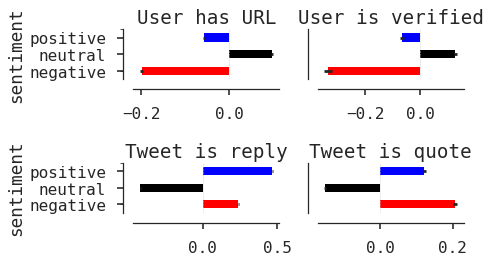

In [15]:
%%time
with sns.axes_style(rc={"font.family": "monospace"}):
    fig, ax = plt.subplots(2,2, sharey=True, figsize=(7,4))
    for i, (grouping, title, axi) in enumerate(zip(
        ["has_url", "is_verified", "is_reply", "is_quoted"],
        ["User has URL", "User is verified", "Tweet is reply", "Tweet is quote"],
        ax.flatten()
    )):
        print(grouping, title)
        plot_log_odds_categorical(df_sentiment, grouping, title, axi, color=["r", "k", "b"])
        if i%2 == 1:
            axi.get_yaxis().set_visible(False)

    sns.despine(offset=10)
    fig.tight_layout()
    plt.savefig("figures/Cat_odds_timeline.pdf", bbox_inches="tight")

## User meta data

In [16]:
def get_log_round_udf(round_digits=1, add_1=False):
    def get_log_round(x):
        if add_1:
            x = x + 1
        result = np.round(np.log10(x), round_digits).item()
        return result
    return udf(get_log_round, FloatType())

def get_log_digitized_udf(bins, add_1=False):
    bin_values = ((bins[1:] + bins[:-1])/2)
    def get_log_round(x):
        if add_1:
            x = x + 1
        result = min(np.log10(x), bin_values[-1])
        result = np.digitize(result, bins).item()
        result = float(bin_values[result])
        return result
    return udf(get_log_round, FloatType())

In [17]:
df_sentiment.withColumn(
        "value_count", get_log_round_udf(add_1=False)(grouping)
    ).head()

Row(tid=911509105344466945, len_hashtags=1, len_urls=2, len_user_mentions=1, created_at='Sat Sep 23 08:34:40 +0000 2017', is_reply=True, is_quoted=False, is_retweet=False, uid=492532196, user_since='Tue Feb 14 20:42:15 +0000 2012', is_verified=True, has_url=True, followers_count=85484, friends_count=0, statuses_count=7554314, compound_score=0.0, negative=0.0, neutral=1.0, positive=0.0, user_age=2047, sentiment='neutral', value_count=-inf)

In [18]:
df_sentiment.withColumn(
        "value_count", get_log_digitized_udf(np.arange(-1.25,7.25,0.5), add_1=False)("followers_count")
    ).head()

Row(tid=911509105344466945, len_hashtags=1, len_urls=2, len_user_mentions=1, created_at='Sat Sep 23 08:34:40 +0000 2017', is_reply=True, is_quoted=False, is_retweet=False, uid=492532196, user_since='Tue Feb 14 20:42:15 +0000 2012', is_verified=True, has_url=True, followers_count=85484, friends_count=0, statuses_count=7554314, compound_score=0.0, negative=0.0, neutral=1.0, positive=0.0, user_age=2047, sentiment='neutral', value_count=5.5)

In [19]:
def plot_log_odds_numerical(
    df_sentiment, grouping, title, ax, value_fn, add_ylabel=True,
):
    df_t = df_sentiment.withColumn(
        "value_count", 
        #get_log_round_udf(**kwargs)(grouping)
        value_fn(grouping)
    ).groupby("sentiment", "value_count").count().toPandas()
    
    df_pivot = df_t.pivot("value_count", "sentiment", "count")
    
    df_tt = df_pivot.divide(
        df_pivot.sum(axis=1),
        axis=0
    ).apply(
        lambda x: np.log(x/(1-x))).apply(
        lambda x: x-x.iloc[x.shape[0]//2])
    for axi, k, color in zip(ax.flatten(), SENTIMENT_KEYS, SENTIMENT_COLORS):
        df_tt[k].plot(color=color, marker="o", ax=axi, linestyle="none", alpha=0.7, ms=5)
        axi.axhline(y=0, linestyle="--", color="0.8", lw=0.5)
        axi.axvline(x=df_tt[k].index[df_tt[k].shape[0]//2], linestyle="--", color="0.8", lw=0.5)
        axi.set_xlabel(title)
        if add_ylabel:
            axi.set_ylabel(k)
        fit_model_plot(df_pivot, k, color, axi)
        
        
def fit_model_plot(df_t, sentiment, color, axi):
    df_tt = df_t.assign(
        success=lambda x: x[sentiment], 
        failure=lambda x: x[[k for k in SENTIMENT_KEYS if k!=sentiment]].sum(axis=1)
    )[["success", "failure"]].fillna(0.).reset_index()
    model = sm.GLM(
        df_tt[["success", "failure"]],
        dmatrix("value_count", data=df_tt[["value_count"]], return_type="dataframe"),
        family=sm.families.Binomial())
    res = model.fit()
    print(sentiment)
    display(res.summary2())
    y = res.predict(dmatrix("value_count",
                    data=df_tt[["value_count"]], return_type="dataframe"))
    y = np.log(y/(1-y))
    y = y - y.iloc[y.shape[0]//2]
    axi.plot(df_tt.value_count, y, color=color, linewidth=1, linestyle="--")

statuses_count statuses
positive


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Generalized linear model
====================================================================
Model:              GLM                    AIC:            2564.0560
Link Function:      logit                  BIC:            2381.1441
Dependent Variable: ['success', 'failure'] Log-Likelihood: -1280.0  
Date:               2018-05-10 01:34       LL-Null:        -2988.2  
No. Observations:   15                     Deviance:       2416.3   
Df Model:           1                      Pearson chi2:   0.0899   
Df Residuals:       13                     Scale:          1.0000   
Method:             IRLS                                            
---------------------------------------------------------------------
                Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
---------------------------------------------------------------------
Intercept      -2.8042    0.0068  -410.2711  0.0000  -2.8176  -2.7908
value_count    -0.0871    0.0015   -58.6883  0.0000  -0.0900  -0.0842
====================================================================

"""

neutral


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Generalized linear model
====================================================================
Model:              GLM                    AIC:            5570.4285
Link Function:      logit                  BIC:            5383.8703
Dependent Variable: ['success', 'failure'] Log-Likelihood: -2783.2  
Date:               2018-05-10 01:34       LL-Null:        -2829.8  
No. Observations:   15                     Deviance:       5419.1   
Df Model:           1                      Pearson chi2:   0.147    
Df Residuals:       13                     Scale:          1.0000   
Method:             IRLS                                            
----------------------------------------------------------------------
               Coef.    Std.Err.      z       P>|z|    [0.025   0.975]
----------------------------------------------------------------------
Intercept      2.8037     0.0060   469.8803   0.0000   2.7920   2.8154
value_count    0.0124     0.0013     9.6540   0.0000   0.0099   0.0149
====================================================================

"""

negative


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Generalized linear model
====================================================================
Model:              GLM                    AIC:            4268.5960
Link Function:      logit                  BIC:            4103.4725
Dependent Variable: ['success', 'failure'] Log-Likelihood: -2132.3  
Date:               2018-05-10 01:34       LL-Null:        -5040.2  
No. Observations:   15                     Deviance:       4138.7   
Df Model:           1                      Pearson chi2:   0.0631   
Df Residuals:       13                     Scale:          1.0000   
Method:             IRLS                                            
---------------------------------------------------------------------
                Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
---------------------------------------------------------------------
Intercept      -5.0452    0.0117  -431.3197  0.0000  -5.0682  -5.0223
value_count     0.1861    0.0025    75.5083  0.0000   0.1812   0.1909
====================================================================

"""

followers_count followers
positive


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Generalized linear model
====================================================================
Model:              GLM                    AIC:            2539.2270
Link Function:      logit                  BIC:            2321.3313
Dependent Variable: ['success', 'failure'] Log-Likelihood: -1267.6  
Date:               2018-05-10 01:34       LL-Null:        -1336.6  
No. Observations:   17                     Deviance:       2363.8   
Df Model:           1                      Pearson chi2:   0.0599   
Df Residuals:       15                     Scale:          1.0000   
Method:             IRLS                                            
---------------------------------------------------------------------
                Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
---------------------------------------------------------------------
Intercept      -3.1440    0.0051  -622.3577  0.0000  -3.1539  -3.1341
value_count    -0.0172    0.0015   -11.7349  0.0000  -0.0201  -0.0144
====================================================================

"""

neutral


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Generalized linear model
====================================================================
Model:              GLM                    AIC:            8072.5803
Link Function:      logit                  BIC:            7850.4976
Dependent Variable: ['success', 'failure'] Log-Likelihood: -4034.3  
Date:               2018-05-10 01:34       LL-Null:        -4228.1  
No. Observations:   17                     Deviance:       7893.0   
Df Model:           1                      Pearson chi2:   0.0964   
Df Residuals:       15                     Scale:          1.0000   
Method:             IRLS                                            
----------------------------------------------------------------------
               Coef.    Std.Err.      z       P>|z|    [0.025   0.975]
----------------------------------------------------------------------
Intercept      2.7775     0.0043   642.1251   0.0000   2.7691   2.7860
value_count    0.0248     0.0013    19.6718   0.0000   0.0223   0.0272
====================================================================

"""

negative


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Generalized linear model
====================================================================
Model:              GLM                    AIC:            9376.3001
Link Function:      logit                  BIC:            9182.1032
Dependent Variable: ['success', 'failure'] Log-Likelihood: -4686.2  
Date:               2018-05-10 01:34       LL-Null:        -4846.6  
No. Observations:   17                     Deviance:       9224.6   
Df Model:           1                      Pearson chi2:   0.0590   
Df Residuals:       15                     Scale:          1.0000   
Method:             IRLS                                            
---------------------------------------------------------------------
                Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
---------------------------------------------------------------------
Intercept      -4.0416    0.0080  -503.1590  0.0000  -4.0573  -4.0258
value_count    -0.0419    0.0023   -17.8884  0.0000  -0.0465  -0.0373
====================================================================

"""

friends_count friends
positive


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Generalized linear model
=====================================================================
Model:              GLM                    AIC:            11740.5279
Link Function:      logit                  BIC:            11567.5463
Dependent Variable: ['success', 'failure'] Log-Likelihood: -5868.3   
Date:               2018-05-10 01:35       LL-Null:        -5869.3   
No. Observations:   14                     Deviance:       11599.    
Df Model:           1                      Pearson chi2:   0.109     
Df Residuals:       12                     Scale:          1.0000    
Method:             IRLS                                             
----------------------------------------------------------------------
                 Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
----------------------------------------------------------------------
Intercept       -3.1939    0.0056  -575.0058  0.0000  -3.2048  -3.1830
value_count     -0.0025    0.0017    -1.4497  0.1472  -0.0058   0.0009
=====================================================================

"""

neutral


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Generalized linear model
=====================================================================
Model:              GLM                    AIC:            22236.2023
Link Function:      logit                  BIC:            22059.4167
Dependent Variable: ['success', 'failure'] Log-Likelihood: -11116.   
Date:               2018-05-10 01:35       LL-Null:        -11143.   
No. Observations:   14                     Deviance:       22091.    
Df Model:           1                      Pearson chi2:   0.161     
Df Residuals:       12                     Scale:          1.0000    
Method:             IRLS                                             
-----------------------------------------------------------------------
                Coef.    Std.Err.      z       P>|z|    [0.025   0.975]
-----------------------------------------------------------------------
Intercept       2.8264     0.0047   595.4896   0.0000   2.8171   2.8357
value_count     0.0108     0.0015     7.3494   0.0000   0.0079   0.0136
=====================================================================

"""

negative


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Generalized linear model
=====================================================================
Model:              GLM                    AIC:            11728.4928
Link Function:      logit                  BIC:            11569.1678
Dependent Variable: ['success', 'failure'] Log-Likelihood: -5862.2   
Date:               2018-05-10 01:35       LL-Null:        -5926.5   
No. Observations:   14                     Deviance:       11601.    
Df Model:           1                      Pearson chi2:   0.0527    
Df Residuals:       12                     Scale:          1.0000    
Method:             IRLS                                             
----------------------------------------------------------------------
                 Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
----------------------------------------------------------------------
Intercept       -4.0845    0.0088  -465.9906  0.0000  -4.1016  -4.0673
value_count     -0.0308    0.0027   -11.3569  0.0000  -0.0361  -0.0255
=====================================================================

"""

user_age user age
positive


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Generalized linear model
===================================================================
Model:              GLM                    AIC:            291.0285
Link Function:      logit                  BIC:            184.2689
Dependent Variable: ['success', 'failure'] Log-Likelihood: -143.51 
Date:               2018-05-10 01:38       LL-Null:        -2008.2 
No. Observations:   8                      Deviance:       196.75  
Df Model:           1                      Pearson chi2:   0.00216 
Df Residuals:       6                      Scale:          1.0000  
Method:             IRLS                                           
--------------------------------------------------------------------
               Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
--------------------------------------------------------------------
Intercept     -2.5616    0.0102  -250.0054  0.0000  -2.5816  -2.5415
value_count   -0.1721    0.0027   -62.6597  0.0000  -0.1775  -0.1667
===================================================================

"""

neutral


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Generalized linear model
===================================================================
Model:              GLM                    AIC:            642.4966
Link Function:      logit                  BIC:            533.6242
Dependent Variable: ['success', 'failure'] Log-Likelihood: -319.25 
Date:               2018-05-10 01:38       LL-Null:        -2260.5 
No. Observations:   8                      Deviance:       546.10  
Df Model:           1                      Pearson chi2:   0.00367 
Df Residuals:       6                      Scale:          1.0000  
Method:             IRLS                                           
---------------------------------------------------------------------
              Coef.    Std.Err.      z       P>|z|    [0.025   0.975]
---------------------------------------------------------------------
Intercept     2.2963     0.0089   258.2359   0.0000   2.2788   2.3137
value_count   0.1516     0.0024    63.6662   0.0000   0.1470   0.1563
===================================================================

"""

negative


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Generalized linear model
===================================================================
Model:              GLM                    AIC:            659.0535
Link Function:      logit                  BIC:            561.1092
Dependent Variable: ['success', 'failure'] Log-Likelihood: -327.53 
Date:               2018-05-10 01:38       LL-Null:        -496.08 
No. Observations:   8                      Deviance:       573.59  
Df Model:           1                      Pearson chi2:   0.00233 
Df Residuals:       6                      Scale:          1.0000  
Method:             IRLS                                           
--------------------------------------------------------------------
               Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
--------------------------------------------------------------------
Intercept     -3.8672    0.0170  -227.5890  0.0000  -3.9005  -3.8339
value_count   -0.0845    0.0045   -18.6027  0.0000  -0.0934  -0.0756
===================================================================

"""

CPU times: user 3.94 s, sys: 72 ms, total: 4.01 s
Wall time: 4min 41s


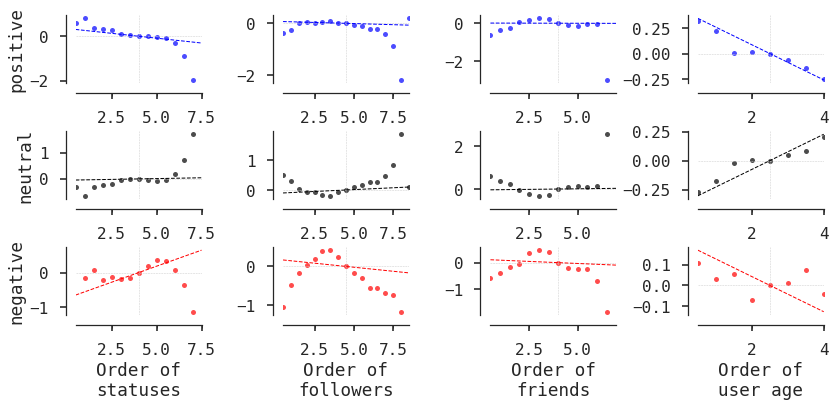

In [20]:
%%time
with sns.axes_style(rc={"font.family": "monospace"}):
    fig, ax = plt.subplots(3,4, sharex="col", figsize=(12,6))
    for i, (grouping, title, add_1, axi) in enumerate(zip(
        ["statuses_count", "followers_count", "friends_count", "user_age"],
        ["statuses", "followers", "friends", "user age"],
        [False, True, True, True],
        ax.T
    )):
        print(grouping, title)
        add_ylabel=True
        if i > 0:
            add_ylabel=False
        plot_log_odds_numerical(
            df_sentiment,
            grouping,
            "Order of\n{}".format(title),
            axi, 
            value_fn=get_log_digitized_udf(
                add_1=add_1,
                bins=np.arange(-1.25,9.5,0.5)
            ),
            add_ylabel=add_ylabel)
        #if i > 0:
        #    for axii in axi:
        #        axii.get_yaxis().set_visible(False)

    sns.despine(offset=10)
    fig.tight_layout(h_pad=0., w_pad=0.01)
    plt.savefig("figures/User_odds_timeline.pdf", bbox_inches="tight")

In [21]:
df_sentiment.withColumn("statuses_friends", sum([col("statuses_count"), col("friends_count")])).head()

Row(tid=911509105344466945, len_hashtags=1, len_urls=2, len_user_mentions=1, created_at='Sat Sep 23 08:34:40 +0000 2017', is_reply=True, is_quoted=False, is_retweet=False, uid=492532196, user_since='Tue Feb 14 20:42:15 +0000 2012', is_verified=True, has_url=True, followers_count=85484, friends_count=0, statuses_count=7554314, compound_score=0.0, negative=0.0, neutral=1.0, positive=0.0, user_age=2047, sentiment='neutral', statuses_friends=7554314)

In [22]:
def get_ratio_udf(round_digits=1, add_1=False):
    def get_log_round(x, y):
        if add_1:
            x = x + 1
            y = y + 1
        result = (np.log10(x)/(np.log10(y) + 1))
        result = np.round(result, round_digits).item()
        return result
    return udf(get_log_round, FloatType())

def get_ratio_digitized_udf(bins, add_1=False):
    bin_values = ((bins[1:] + bins[:-1])/2)
    def get_log_round(x,y):
        if add_1:
            x = x + 1
            y = y + 1
        result = min(np.log10(x)/(np.log10(y) + 1), bin_values[-1])
        result = np.digitize(result, bins).item()
        result = float(bin_values[result])
        return result
    return udf(get_log_round, FloatType())

In [23]:
def plot_log_odds_ratio(df_sentiment, grouping, title, ax, value_fn, add_ylabel=True):
    df_t = df_sentiment.withColumn(
        "value_count", value_fn(col(grouping[0]), col(grouping[1]))
    ).groupby("sentiment", "value_count").count().toPandas()
    
    df_pivot = df_t.pivot("value_count", "sentiment", "count")
    #print(df_pivot.columns)
    #print(df_pivot.index)
    df_tt = df_pivot.divide(
        df_pivot.sum(axis=1),
        axis=0
    ).apply(
        lambda x: np.log(x/(1-x))).apply(
        lambda x: x-x.iloc[x.shape[0]//2])
    for axi, k, color in zip(ax.flatten(), SENTIMENT_KEYS, SENTIMENT_COLORS):
        df_tt[k].plot(color=color, marker="o", ax=axi, linestyle="none", alpha=0.7, ms=5)
        axi.axhline(y=0, linestyle="--", color="0.8", lw=0.5)
        axi.axvline(x=df_tt[k].index[df_tt[k].shape[0]//2], linestyle="--", color="0.8", lw=0.5)
        axi.set_xlabel(title)
        if add_ylabel:
            axi.set_ylabel(k)
        fit_model_plot(df_pivot, k, color, axi)

('statuses_count', 'followers_count') statuses/followers
positive


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Generalized linear model
====================================================================
Model:              GLM                    AIC:            1412.0326
Link Function:      logit                  BIC:            1290.8127
Dependent Variable: ['success', 'failure'] Log-Likelihood: -704.02  
Date:               2018-05-10 01:39       LL-Null:        -3482.0  
No. Observations:   12                     Deviance:       1315.7   
Df Model:           1                      Pearson chi2:   0.104    
Df Residuals:       10                     Scale:          1.0000   
Method:             IRLS                                            
---------------------------------------------------------------------
                Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
---------------------------------------------------------------------
Intercept      -2.6201    0.0081  -321.6414  0.0000  -2.6361  -2.6041
value_count    -0.3761    0.0052   -71.6994  0.0000  -0.3864  -0.3658
====================================================================

"""

neutral


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Generalized linear model
====================================================================
Model:              GLM                    AIC:            4115.1108
Link Function:      logit                  BIC:            3990.9447
Dependent Variable: ['success', 'failure'] Log-Likelihood: -2055.6  
Date:               2018-05-10 01:39       LL-Null:        -3867.8  
No. Observations:   12                     Deviance:       4015.8   
Df Model:           1                      Pearson chi2:   0.175    
Df Residuals:       10                     Scale:          1.0000   
Method:             IRLS                                            
----------------------------------------------------------------------
               Coef.    Std.Err.      z       P>|z|    [0.025   0.975]
----------------------------------------------------------------------
Intercept      2.4682     0.0068   365.6310   0.0000   2.4550   2.4815
value_count    0.2532     0.0043    58.5103   0.0000   0.2447   0.2617
====================================================================

"""

negative


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Generalized linear model
====================================================================
Model:              GLM                    AIC:            6225.2900
Link Function:      logit                  BIC:            6117.6244
Dependent Variable: ['success', 'failure'] Log-Likelihood: -3110.6  
Date:               2018-05-10 01:39       LL-Null:        -3122.7  
No. Observations:   12                     Deviance:       6142.5   
Df Model:           1                      Pearson chi2:   0.0986   
Df Residuals:       10                     Scale:          1.0000   
Method:             IRLS                                            
---------------------------------------------------------------------
                Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
---------------------------------------------------------------------
Intercept      -4.2376    0.0114  -371.1188  0.0000  -4.2600  -4.2152
value_count     0.0357    0.0072     4.9293  0.0000   0.0215   0.0498
====================================================================

"""

('statuses_count', 'friends_count') statuses/friends
positive


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Generalized linear model
====================================================================
Model:              GLM                    AIC:            2863.0183
Link Function:      logit                  BIC:            2701.5644
Dependent Variable: ['success', 'failure'] Log-Likelihood: -1429.5  
Date:               2018-05-10 01:39       LL-Null:        -4370.1  
No. Observations:   15                     Deviance:       2736.8   
Df Model:           1                      Pearson chi2:   0.0332   
Df Residuals:       13                     Scale:          1.0000   
Method:             IRLS                                            
---------------------------------------------------------------------
                Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
---------------------------------------------------------------------
Intercept      -2.8224    0.0054  -527.1284  0.0000  -2.8329  -2.8119
value_count    -0.2333    0.0032   -71.8354  0.0000  -0.2397  -0.2269
====================================================================

"""

neutral


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Generalized linear model
====================================================================
Model:              GLM                    AIC:            7494.9492
Link Function:      logit                  BIC:            7327.3884
Dependent Variable: ['success', 'failure'] Log-Likelihood: -3745.5  
Date:               2018-05-10 01:39       LL-Null:        -5685.4  
No. Observations:   15                     Deviance:       7362.6   
Df Model:           1                      Pearson chi2:   0.0800   
Df Residuals:       13                     Scale:          1.0000   
Method:             IRLS                                            
----------------------------------------------------------------------
               Coef.    Std.Err.      z       P>|z|    [0.025   0.975]
----------------------------------------------------------------------
Intercept      2.6074     0.0043   601.3531   0.0000   2.5989   2.6159
value_count    0.1552     0.0026    59.5438   0.0000   0.1501   0.1603
====================================================================

"""

negative


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Generalized linear model
====================================================================
Model:              GLM                    AIC:            8073.1753
Link Function:      logit                  BIC:            7923.0713
Dependent Variable: ['success', 'failure'] Log-Likelihood: -4034.6  
Date:               2018-05-10 01:39       LL-Null:        -4040.7  
No. Observations:   15                     Deviance:       7958.3   
Df Model:           1                      Pearson chi2:   0.0793   
Df Residuals:       13                     Scale:          1.0000   
Method:             IRLS                                            
---------------------------------------------------------------------
                Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
---------------------------------------------------------------------
Intercept      -4.2062    0.0071  -593.1505  0.0000  -4.2201  -4.1923
value_count     0.0147    0.0042     3.5238  0.0004   0.0065   0.0228
====================================================================

"""

('followers_count', 'friends_count') followers/friends
positive


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Generalized linear model
====================================================================
Model:              GLM                    AIC:            3302.1088
Link Function:      logit                  BIC:            3166.6105
Dependent Variable: ['success', 'failure'] Log-Likelihood: -1649.1  
Date:               2018-05-10 01:40       LL-Null:        -1829.8  
No. Observations:   13                     Deviance:       3194.8   
Df Model:           1                      Pearson chi2:   0.135    
Df Residuals:       11                     Scale:          1.0000   
Method:             IRLS                                            
---------------------------------------------------------------------
                Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
---------------------------------------------------------------------
Intercept      -3.1158    0.0047  -665.0274  0.0000  -3.1249  -3.1066
value_count    -0.0668    0.0035   -18.8843  0.0000  -0.0737  -0.0599
====================================================================

"""

neutral


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Generalized linear model
====================================================================
Model:              GLM                    AIC:            6079.0130
Link Function:      logit                  BIC:            5939.4714
Dependent Variable: ['success', 'failure'] Log-Likelihood: -3037.5  
Date:               2018-05-10 01:40       LL-Null:        -3221.3  
No. Observations:   13                     Deviance:       5967.7   
Df Model:           1                      Pearson chi2:   0.201    
Df Residuals:       11                     Scale:          1.0000   
Method:             IRLS                                            
----------------------------------------------------------------------
               Coef.    Std.Err.      z       P>|z|    [0.025   0.975]
----------------------------------------------------------------------
Intercept      2.7864     0.0040   695.9438   0.0000   2.7786   2.7943
value_count    0.0576     0.0030    19.0632   0.0000   0.0516   0.0635
====================================================================

"""

negative


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Generalized linear model
====================================================================
Model:              GLM                    AIC:            3356.1634
Link Function:      logit                  BIC:            3233.7631
Dependent Variable: ['success', 'failure'] Log-Likelihood: -1676.1  
Date:               2018-05-10 01:40       LL-Null:        -1690.6  
No. Observations:   13                     Deviance:       3262.0   
Df Model:           1                      Pearson chi2:   0.0664   
Df Residuals:       11                     Scale:          1.0000   
Method:             IRLS                                            
---------------------------------------------------------------------
                Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
---------------------------------------------------------------------
Intercept      -4.1434    0.0074  -559.6027  0.0000  -4.1580  -4.1289
value_count    -0.0299    0.0056    -5.3714  0.0000  -0.0409  -0.0190
====================================================================

"""

CPU times: user 2.96 s, sys: 36 ms, total: 3 s
Wall time: 2min 20s


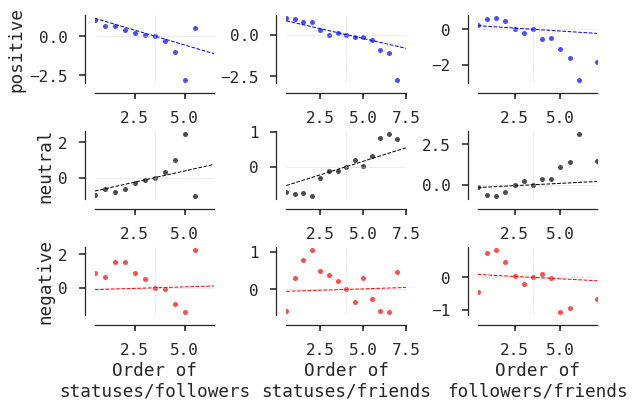

In [24]:
%%time
with sns.axes_style(rc={"font.family": "monospace"}):
    fig, ax = plt.subplots(3,3, sharex="col", figsize=(9,6))
    for i, (grouping, title, add_1, axi) in enumerate(zip(
        [
            ("statuses_count", "followers_count"),
            ("statuses_count", "friends_count"),
            ("followers_count", "friends_count"),
        ],
        [
            "statuses/followers",
            "statuses/friends",
            "followers/friends"
        ],
        [True, True, True],
        ax.T
    )):
        print(grouping, title)
        add_ylabel=True
        if i > 0:
            add_ylabel=False
        plot_log_odds_ratio(
            df_sentiment,
            grouping,
            "Order of\n{}".format(title),
            axi, 
            get_ratio_digitized_udf(bins=np.arange(-1.25,9.5,0.5), add_1=add_1),
            add_ylabel=add_ylabel
        )

    sns.despine(offset=10)
    fig.tight_layout(h_pad=0., w_pad=0.01)
    plt.savefig("figures/User_ratio_odds_timeline.pdf", bbox_inches="tight")

## Tweet numeric metadata

In [25]:
df_sentiment.head()

Row(tid=911509105344466945, len_hashtags=1, len_urls=2, len_user_mentions=1, created_at='Sat Sep 23 08:34:40 +0000 2017', is_reply=True, is_quoted=False, is_retweet=False, uid=492532196, user_since='Tue Feb 14 20:42:15 +0000 2012', is_verified=True, has_url=True, followers_count=85484, friends_count=0, statuses_count=7554314, compound_score=0.0, negative=0.0, neutral=1.0, positive=0.0, user_age=2047, sentiment='neutral')

In [26]:
df_sentiment[df_sentiment["len_user_mentions"] == 50].head()

Row(tid=902885983921852416, len_hashtags=0, len_urls=0, len_user_mentions=50, created_at='Wed Aug 30 13:29:28 +0000 2017', is_reply=True, is_quoted=False, is_retweet=False, uid=1315713750, user_since='Sat Mar 30 04:09:04 +0000 2013', is_verified=False, has_url=False, followers_count=201, friends_count=223, statuses_count=1422, compound_score=0.5514000058174133, negative=0.0, neutral=0.9399999976158142, positive=0.05999999865889549, user_age=1614, sentiment='neutral')

In [27]:
df_pivot = df_sentiment.withColumn(
    "value_count",
    col("len_user_mentions")
).groupby("sentiment", "value_count").count().toPandas().pivot(
    "value_count",
    "sentiment",
    "count"
).fillna(0.)
df_pivot

sentiment,negative,neutral,positive
value_count,,,
0,179330.0,7548118.0,340921.0
1,115978.0,9320034.0,393154.0
2,10546.0,1656487.0,54013.0
3,1312.0,482424.0,8721.0
4,240.0,161887.0,1855.0
5,55.0,68054.0,500.0
6,12.0,33507.0,172.0
7,4.0,18651.0,68.0
8,5.0,12552.0,24.0


In [28]:
def plot_log_odds_ratio_tweet(
    df_sentiment, grouping, title, ax,
    add_ylabel=True, clip=None
):
    if clip and len(clip) == 2:
        df_sentiment = df_sentiment.withColumn(
            grouping,
            when(
                df_sentiment[grouping] < clip[0], clip[0]
            ).otherwise(
                when(
                    df_sentiment[grouping] > clip[1], clip[1]
                ).otherwise(df_sentiment[grouping])
            )
        )
    df_t = df_sentiment.withColumn(
        "value_count", col(grouping)
    ).groupby("sentiment", "value_count").count().toPandas()
    
    df_pivot = df_t.pivot("value_count", "sentiment", "count").fillna(0.)
    df_tt = (df_pivot + 1).divide(
        df_pivot.sum(axis=1) + 3,
        axis=0
    ).apply(
        lambda x: np.log(x/(1-x))
    ).apply(
        lambda x: x-x.iloc[x.shape[0]//2]
    )
    """
    df_tt = df_pivot.divide(
        df_pivot.sum(axis=1),
        axis=0
    ).apply(
        lambda x: np.log(x/(1-x))).apply(
        lambda x: x-x.iloc[x.shape[0]//2])
    """
    for axi, k, color in zip(ax.flatten(), SENTIMENT_KEYS, SENTIMENT_COLORS):
        df_tt[k].plot(color=color, marker="o", ax=axi, linestyle="none", alpha=0.7, ms=5)
        axi.axhline(y=0, linestyle="--", color="0.8", lw=0.5)
        axi.axvline(x=df_tt[k].index[df_tt[k].shape[0]//2], linestyle="--", color="0.8", lw=0.5)
        axi.set_xlabel(title)
        if add_ylabel:
            axi.set_ylabel(k)
        fit_model_plot(df_pivot, k, color, axi)

len_user_mentions mentions
positive


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Generalized linear model
====================================================================
Model:              GLM                    AIC:            7166.3383
Link Function:      logit                  BIC:            7043.1318
Dependent Variable: ['success', 'failure'] Log-Likelihood: -3581.2  
Date:               2018-05-10 01:41       LL-Null:        -13218.  
No. Observations:   11                     Deviance:       7064.7   
Df Model:           1                      Pearson chi2:   0.0443   
Df Residuals:       9                      Scale:          1.0000   
Method:             IRLS                                            
---------------------------------------------------------------------
               Coef.   Std.Err.      z       P>|z|    [0.025   0.975]
---------------------------------------------------------------------
Intercept     -3.0601    0.0015  -2020.0379  0.0000  -3.0631  -3.0571
value_count   -0.1915    0.0015   -130.4677  0.0000  -0.1944  -0.1886
====================================================================

"""

neutral


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Generalized linear model
====================================================================
Model:              GLM                    AIC:            3675.7058
Link Function:      logit                  BIC:            3551.0094
Dependent Variable: ['success', 'failure'] Log-Likelihood: -1835.9  
Date:               2018-05-10 01:41       LL-Null:        -31526.  
No. Observations:   11                     Deviance:       3572.6   
Df Model:           1                      Pearson chi2:   0.0206   
Df Residuals:       9                      Scale:          1.0000   
Method:             IRLS                                            
----------------------------------------------------------------------
              Coef.    Std.Err.       z       P>|z|    [0.025   0.975]
----------------------------------------------------------------------
Intercept     2.6443     0.0013   2042.9572   0.0000   2.6417   2.6468
value_count   0.3055     0.0014    224.8131   0.0000   0.3028   0.3081
====================================================================

"""

negative


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Generalized linear model
===================================================================
Model:              GLM                    AIC:            142.6293
Link Function:      logit                  BIC:            45.2916 
Dependent Variable: ['success', 'failure'] Log-Likelihood: -69.315 
Date:               2018-05-10 01:41       LL-Null:        -29844. 
No. Observations:   11                     Deviance:       66.873  
Df Model:           1                      Pearson chi2:   0.000863
Df Residuals:       9                      Scale:          1.0000  
Method:             IRLS                                           
--------------------------------------------------------------------
              Coef.   Std.Err.      z       P>|z|    [0.025   0.975]
--------------------------------------------------------------------
Intercept    -3.7805    0.0023  -1646.0688  0.0000  -3.7850  -3.7760
value_count  -0.6551    0.0030   -218.0291  0.0000  -0.6610  -0.6492
===================================================================

"""

len_hashtags hashtags
positive


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Generalized linear model
===================================================================
Model:              GLM                    AIC:            909.2347
Link Function:      logit                  BIC:            782.0745
Dependent Variable: ['success', 'failure'] Log-Likelihood: -452.62 
Date:               2018-05-10 01:41       LL-Null:        -49571. 
No. Observations:   16                     Deviance:       820.89  
Df Model:           1                      Pearson chi2:   0.490   
Df Residuals:       14                     Scale:          1.0000  
Method:             IRLS                                           
--------------------------------------------------------------------
              Coef.   Std.Err.      z       P>|z|    [0.025   0.975]
--------------------------------------------------------------------
Intercept    -3.0660    0.0012  -2587.1528  0.0000  -3.0683  -3.0637
value_count  -0.7294    0.0031   -237.6086  0.0000  -0.7354  -0.7233
===================================================================

"""

neutral


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Generalized linear model
====================================================================
Model:              GLM                    AIC:            1988.1276
Link Function:      logit                  BIC:            1855.5391
Dependent Variable: ['success', 'failure'] Log-Likelihood: -992.06  
Date:               2018-05-10 01:41       LL-Null:        -80525.  
No. Observations:   16                     Deviance:       1894.4   
Df Model:           1                      Pearson chi2:   5.57     
Df Residuals:       14                     Scale:          1.0000   
Method:             IRLS                                            
----------------------------------------------------------------------
              Coef.    Std.Err.       z       P>|z|    [0.025   0.975]
----------------------------------------------------------------------
Intercept     2.7128     0.0010   2676.9369   0.0000   2.7108   2.7147
value_count   0.8387     0.0028    294.6309   0.0000   0.8331   0.8443
====================================================================

"""

negative


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Generalized linear model
===================================================================
Model:              GLM                    AIC:            900.8935
Link Function:      logit                  BIC:            787.0265
Dependent Variable: ['success', 'failure'] Log-Likelihood: -448.45 
Date:               2018-05-10 01:41       LL-Null:        -31622. 
No. Observations:   16                     Deviance:       825.84  
Df Model:           1                      Pearson chi2:   469.    
Df Residuals:       14                     Scale:          1.0000  
Method:             IRLS                                           
--------------------------------------------------------------------
              Coef.   Std.Err.      z       P>|z|    [0.025   0.975]
--------------------------------------------------------------------
Intercept    -4.0143    0.0019  -2157.1308  0.0000  -4.0179  -4.0106
value_count  -1.1868    0.0070   -168.4056  0.0000  -1.2006  -1.1730
===================================================================

"""

len_urls URLs
positive


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Generalized linear model
===================================================================
Model:              GLM                    AIC:            288.9343
Link Function:      logit                  BIC:            232.2086
Dependent Variable: ['success', 'failure'] Log-Likelihood: -142.47 
Date:               2018-05-10 01:42       LL-Null:        -20019. 
No. Observations:   7                      Deviance:       241.94  
Df Model:           1                      Pearson chi2:   0.0161  
Df Residuals:       5                      Scale:          1.0000  
Method:             IRLS                                           
--------------------------------------------------------------------
              Coef.   Std.Err.      z       P>|z|    [0.025   0.975]
--------------------------------------------------------------------
Intercept    -3.0683    0.0013  -2398.1650  0.0000  -3.0709  -3.0658
value_count  -0.5236    0.0028   -189.3501  0.0000  -0.5291  -0.5182
===================================================================

"""

neutral


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Generalized linear model
===================================================================
Model:              GLM                    AIC:            580.7980
Link Function:      logit                  BIC:            523.0356
Dependent Variable: ['success', 'failure'] Log-Likelihood: -288.40 
Date:               2018-05-10 01:42       LL-Null:        -29314. 
No. Observations:   7                      Deviance:       532.77  
Df Model:           1                      Pearson chi2:   0.0226  
Df Residuals:       5                      Scale:          1.0000  
Method:             IRLS                                           
--------------------------------------------------------------------
                 Coef.   Std.Err.      z      P>|z|   [0.025  0.975]
--------------------------------------------------------------------
Intercept        2.7225    0.0011  2483.8847  0.0000  2.7203  2.7246
value_count      0.5425    0.0024   228.6426  0.0000  0.5378  0.5471
===================================================================

"""

negative


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Generalized linear model
===================================================================
Model:              GLM                    AIC:            450.3897
Link Function:      logit                  BIC:            398.4476
Dependent Variable: ['success', 'failure'] Log-Likelihood: -223.19 
Date:               2018-05-10 01:42       LL-Null:        -8789.6 
No. Observations:   7                      Deviance:       408.18  
Df Model:           1                      Pearson chi2:   0.00753 
Df Residuals:       5                      Scale:          1.0000  
Method:             IRLS                                           
--------------------------------------------------------------------
              Coef.   Std.Err.      z       P>|z|    [0.025   0.975]
--------------------------------------------------------------------
Intercept    -4.0438    0.0020  -1995.5832  0.0000  -4.0478  -4.0398
value_count  -0.5530    0.0045   -123.5690  0.0000  -0.5617  -0.5442
===================================================================

"""

CPU times: user 2.9 s, sys: 40 ms, total: 2.94 s
Wall time: 58.9 s


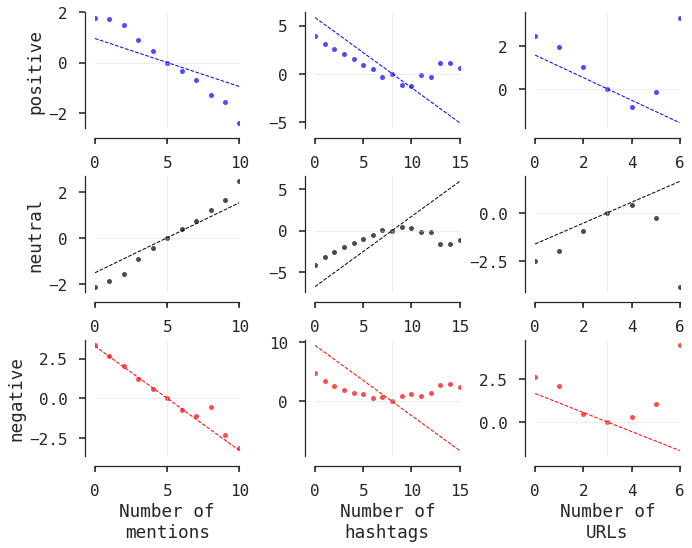

In [29]:
%%time
with sns.axes_style(rc={"font.family": "monospace"}):
    fig, ax = plt.subplots(3,3, sharex="col", figsize=(10,8))
    for i, (grouping, title, clip, axi) in enumerate(zip(
        [
            "len_user_mentions",
            "len_hashtags",
            "len_urls",
        ],
        [
            "mentions",
            "hashtags",
            "URLs"
        ],
        [(0, 10), (0, 15), None],
        ax.T
    )):
        print(grouping, title)
        add_ylabel=True
        if i > 0:
            add_ylabel=False
        plot_log_odds_ratio_tweet(
            df_sentiment,
            grouping,
            "Number of\n{}".format(title),
            axi, clip=clip,
            add_ylabel=add_ylabel)

    sns.despine(offset=10)
    fig.tight_layout(h_pad=0., w_pad=0.01)
    plt.savefig("figures/Tweet_odds_timeline.pdf", bbox_inches="tight")